In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
from pinecone import Pinecone
from langchain_huggingface import HuggingFaceEmbeddings
import os

In [4]:
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Bangla RAG Agent"

In [5]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [6]:
pc = Pinecone(api_key=pinecone_api_key)
index_name = "10ms-db-bangla-book"

index = pc.Index(index_name)
index

In [7]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [8]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [9]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [10]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

Rag Prompt

Adding LTM

In [11]:
from pydantic import BaseModel, Field
from typing import List, Optional

class StudentProfile(BaseModel):
    """A profile for a student user to personalize interactions."""
    user_name: Optional[str] = Field(
        description="The student's name, if they mention it.",
        default=None
    )
    grade_or_class: Optional[str] = Field(
        description="The student's academic grade or class (e.g., 'Class 10', 'HSC Candidate').",
        default=None
    )
    topics_of_interest: List[str] = Field(
        description="A list of subjects or specific topics the student has asked about (e.g., 'কবিতা', 'অপরিচিতা', 'ব্যাকরণ').",
        default_factory=list
    )
    last_topic_discussed: Optional[str] = Field(
        description="The main topic of the last question asked by the user to maintain context.",
        default=None
    )

Defining the Graph State

In [12]:
from typing import TypedDict, Sequence, Annotated, Literal
from langchain_core.messages import BaseMessage
import operator

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: The history of messages in the current conversation.
        docs: The documents retrieved from the vector store for the current question.
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    docs: list
    grade: Literal['yes', 'no']
    src_docs: str

Setting up the Memory Extactor

In [13]:
from trustcall import create_extractor

memory_extractor = create_extractor(
    llm,
    tools=[StudentProfile],
    tool_choice="StudentProfile",
)

Defining the Graph Nodes

In [14]:
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver

# --- Node 1: Retrieve Documents ---
def retrieve_node(state: GraphState):
    """
    Retrieves documents from the vector store based on the latest user question.
    """
    print("---NODE: RETRIEVE DOCUMENTS---")
    last_message = state["messages"][-1]
    question = last_message.content
    
    # Use the retriever we defined earlier
    retrieved_docs = retriever.invoke(question)
    print(f"Retrieved {len(retrieved_docs)} docs.")
    
    return {"docs": retrieved_docs}

Grade Docs

In [15]:
from typing import Literal
class Grade(BaseModel):
    """This is produce binary output based on the document if relevant then sya yes otherwise say no."""
    binary_output: Literal["yes", "no"] = Field(description="if the document is relevant to the query then say yes otherwise say no")

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage

def grade_document(state: GraphState) ->Literal["yes", "no"]:
    """This function is response for the grade the document like retrieve document is relevant to the question or not."""

    last_message = state["messages"][-1]
    question = last_message.content
    
    context = state["docs"]
    
    system_msg = f"""Your task is to check where the retrieve context is relevant with the question or not like using this context is possible to answer or not. if relevant then just say 'yes' otherwise say no
                    this question is: {question} \n
                    this context is: \n\n
                    {context} \n\n
                    carefully analysis the context and question and produced the output based on the schema.
                    """
    llm_with_str_op = llm.with_structured_output(Grade)
    
    response = llm_with_str_op.invoke([SystemMessage(content=system_msg)])
    print(response.binary_output)
    return {
        "grade": response.binary_output
    }

In [17]:
def route_node(state: GraphState):
    print("reoute node")
    """This function is responsible for the route the node where transform query of generate the response"""
    
    if state['grade'] == 'yes':
        print("the query is relevant.")
        return "relevant_docs"
    else:
        print("This query is not relevant. go to web call")
        return "not_relevant_docs"

Web Search

In [18]:
from langchain_community.utilities import GoogleSerperAPIWrapper

os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
search = GoogleSerperAPIWrapper()


def search_on_web(state: GraphState):
    print("---web search start---")
    last_message = state["messages"][-1]
    question = last_message.content
    
    src_result = search.run(question)
    
    print("---web search end---")
    src_result = str(src_result)
    
    return {
        "src_docs": src_result
    }

Node 2: Generate Response using RAG and Memory

In [19]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [20]:
def generate_node(state: GraphState, config: dict, store: BaseStore):
    """
    Generates a response using the LLM, taking into account the retrieved docs,
    the conversation history, and the user's long-term memory.
    It handles context from either the retriever OR a web search.
    """
    print("---NODE: GENERATE RESPONSE---")
    
    # Get the latest question
    question = state["messages"][-1].content
    
    context_source = ""
    if state.get("src_docs"):
        print("--- Using context from Web Search ---")
        # Web search provides a single string
        context_source = state["src_docs"]
    else:
        print("--- Using context from Retriever ---")
        context_source = format_docs(state["docs"])

    # Get user_id from the config to load long-term memory
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    
    # Try to load existing student profile
    existing_memory = store.get(namespace, "student_profile")
    
    # Format the memories for the prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"ছাত্রের নাম: {memory_dict.get('user_name', 'অজানা')}\n"
            f"ছাত্রের শ্রেণি: {memory_dict.get('grade_or_class', 'অজানা')}\n"
            f"আগ্রহের বিষয়: {', '.join(memory_dict.get('topics_of_interest', ['কিছুই না']))}"
        )
    else:
        formatted_memory = "এই ছাত্রের জন্য কোনো স্মৃতি এখনো জমা হয়নি।"
        
    print(f"Loaded Memory: {formatted_memory}")

    # New prompt that incorporates long-term memory
    rag_with_memory_prompt = PromptTemplate(
        template=(
            "তুমি একজন সহায়ক ও ব্যক্তিগত বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দেওয়ার জন্য প্রদত্ত প্রাসঙ্গিক তথ্য এবং ছাত্রের সম্পর্কে তোমার স্মৃতি ব্যবহার করো।\n\n"
            "## ছাত্রের স্মৃতি:\n{memory}\n\n"
            "## প্রাসঙ্গিক তথ্য:\n{context}\n\n"
            "## প্রশ্ন:\n{question}\n\n"
            "উত্তর (বাংলায় সংক্ষিপ্ত, ব্যক্তিগত এবং স্পষ্টভাবে দাও):"
        ),
        input_variables=["question", "context", "memory"],
    )

    # Simplified chain for this node
    rag_chain = (
        rag_with_memory_prompt
        | llm
        | StrOutputParser()
    )
    
    response = rag_chain.invoke({
        "context": context_source,
        "question": question,
        "memory": formatted_memory
    })
    
    print(f"Generated Response: {response}")
    
    return {"messages": [AIMessage(content=response)]}

Node 3: Update Long-Term Memory (corrected)

In [21]:

def update_memory_node(state: GraphState, config: dict, store: BaseStore):
    """
    Reflects on the most recent exchange and updates the student's profile in the long-term store.
    """
    print("---NODE: UPDATE MEMORY---")
    
    # Get user_id from the config
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    
    # Load existing memory
    existing_memory = store.get(namespace, "student_profile")
    existing_profile = {"StudentProfile": existing_memory.value} if existing_memory else None
    
    # Instruction for the extractor
    extraction_instruction = "নিচের কথোপকথন থেকে ছাত্রের প্রোফাইল তৈরি বা আপডেট করো:"
    
    recent_exchange = state["messages"][-2:]
    
    # Invoke the extractor with the FOCUSED context
    result = memory_extractor.invoke({
        "messages": [SystemMessage(content=extraction_instruction)] + recent_exchange,
        "existing": existing_profile
    })
    
    if result.get("responses"):
        updated_profile = result["responses"][0].model_dump()
        print(f"Updated Profile: {updated_profile}")

        # Save the updated profile to the long-term store
        store.put(namespace, "student_profile", updated_profile)
    else:
        print("No new profile information found to update.")
    return

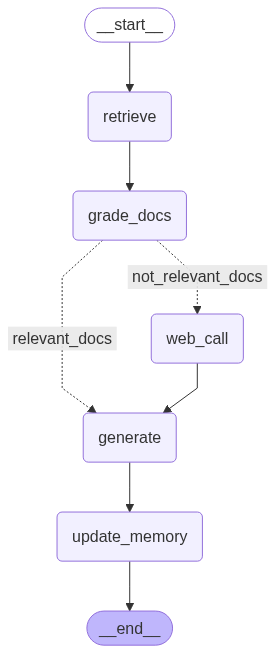

In [22]:
## **Building the Graph**
from langgraph.graph import StateGraph, START, END
from langgraph.store.memory import InMemoryStore
from IPython.display import display, Image

# The store for long-term (across-thread) memory
long_term_store = InMemoryStore()

# The checkpointer for short-term (within-thread) memory
checkpointer = MemorySaver()

# Define the graph
builder = StateGraph(GraphState)

# Add the nodes
builder.add_node("retrieve", retrieve_node)
builder.add_node("grade_docs", grade_document)
builder.add_node("web_call", search_on_web)
builder.add_node("generate", generate_node)
builder.add_node("update_memory", update_memory_node)

# Define the edges (the flow)
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "grade_docs")
builder.add_conditional_edges(
    "grade_docs",
    route_node,
    {
        "relevant_docs": "generate",
        "not_relevant_docs": "web_call"
    }
)
builder.add_edge("web_call", "generate")
builder.add_edge("generate", "update_memory")
builder.add_edge("update_memory", END)

# Compile the graph with both memory systems
graph = builder.compile(checkpointer=checkpointer, store=long_term_store)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
config_user_1 = {
    "configurable": {
        "user_id": "student_Nahid",
        "thread_id": "chat_session_1" 
    }
}

# --- First Interaction ---
print("\n--- FIRST INTERACTION (SESSION 1) ---")
question1 = "আমার নাম Nahid Hasan, আমি দশম শ্রেণিতে পড়ি। 'অপরিচিতা' গল্পে বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"

response = graph.invoke(
    {"messages": [HumanMessage(content=question1)]},
    config=config_user_1
)

print("\nFinal Answer:", response['messages'][-1].content)


--- FIRST INTERACTION (SESSION 1) ---
---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
no
reoute node
This query is not relevant. go to web call
---web search start---
---web search end---
---NODE: GENERATE RESPONSE---
--- Using context from Web Search ---
Loaded Memory: এই ছাত্রের জন্য কোনো স্মৃতি এখনো জমা হয়নি।
Generated Response: আমার মনে আছে, 'অপরিচিতা' গল্পে বিয়ের সময় কল্যাণীর বয়স ছিল বারো বছর।
---NODE: UPDATE MEMORY---
Updated Profile: {'user_name': 'Nahid Hasan', 'grade_or_class': '10', 'topics_of_interest': ['অপৰিচিता'], 'last_topic_discussed': 'অপৰিচিता'}

Final Answer: আমার মনে আছে, 'অপরিচিতা' গল্পে বিয়ের সময় কল্যাণীর বয়স ছিল বারো বছর।


In [29]:
print("\n\n--- SECOND INTERACTION (NEW SESSION) ---")

# Note: We use a *new thread_id* but the *same user_id*
config_user_1_new_session = {
    "configurable": {
        "user_id": "student_nahid",
        "thread_id": "chat_session_2" # New session
    }
}

question2 = "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?"

response2 = graph.invoke(
    {"messages": [HumanMessage(content=question2)]},
    config=config_user_1_new_session
)

print("\nFinal Answer:", response2['messages'][-1].content)

# Check the long-term memory again to see it updated
print("\n--- CHECKING LONG-TERM MEMORY (AFTER 2nd INTERACTION) ---")
nahid_profile_updated = long_term_store.get(("memory", "student_nahid"), "student_profile")
print(nahid_profile_updated.value)



--- SECOND INTERACTION (NEW SESSION) ---
---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
no
reoute node
This query is not relevant. go to web call
---web search start---
---web search end---
---NODE: GENERATE RESPONSE---
--- Using context from Web Search ---
Loaded Memory: ছাত্রের নাম: अनुपम
ছাত্রের শ্রেণি: None
আগ্রহের বিষয়: 
Generated Response: অনুপমের ভাষায় সুপুরুষ বলতে বোঝানো হয়েছে শম্ভুনাথ সেনকে। 

'চুল কাঁচা, গোঁফে পাক ধরিতে আরম্ভ করিয়াছে মাত্র। সুপুরুষ বটে।' 

এখানে 'সুপুরুষ'টি কে সে সম্পর্কে অনুপমের বক্তব্য প্রসঙ্গত উল্লেখযোগ্য। আর সুপুরুষ বলতে এখানে শম্ভুনাথ সেনকেই বোঝানো হয়েছে।
---NODE: UPDATE MEMORY---


Could not apply patch: member 'instance' not found in {'user_name': 'अनुपम', 'grade_or_class': None, 'topics_of_interest': [], 'last_topic_discussed': "What सुपुरुष means in अनुपम's language"}


No new profile information found to update.

Final Answer: অনুপমের ভাষায় সুপুরুষ বলতে বোঝানো হয়েছে শম্ভুনাথ সেনকে। 

'চুল কাঁচা, গোঁফে পাক ধরিতে আরম্ভ করিয়াছে মাত্র। সুপুরুষ বটে।' 

এখানে 'সুপুরুষ'টি কে সে সম্পর্কে অনুপমের বক্তব্য প্রসঙ্গত উল্লেখযোগ্য। আর সুপুরুষ বলতে এখানে শম্ভুনাথ সেনকেই বোঝানো হয়েছে।

--- CHECKING LONG-TERM MEMORY (AFTER 2nd INTERACTION) ---
{'user_name': 'अनुपम', 'grade_or_class': None, 'topics_of_interest': [], 'last_topic_discussed': "What सुपुरुष means in अनुपम's language"}


In [30]:
print("\n\n--- Third INTERACTION (NEW SESSION) ---")

# Note: We use a *new thread_id* but the *same user_id*
config_user_1_new_session = {
    "configurable": {
        "user_id": "student_nahid",
        "thread_id": "chat_session_2" # New session
    }
}

question2 = "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?"

response2 = graph.invoke(
    {"messages": [HumanMessage(content=question2)]},
    config=config_user_1_new_session
)

print("\nFinal Answer:", response2['messages'][-1].content)

# Check the long-term memory again to see it updated
print("\n--- CHECKING LONG-TERM MEMORY (AFTER 2nd INTERACTION) ---")
nahid_profile_updated = long_term_store.get(("memory", "student_nahid"), "student_profile")
print(nahid_profile_updated.value)



--- Third INTERACTION (NEW SESSION) ---
---NODE: RETRIEVE DOCUMENTS---
Retrieved 3 docs.
no
reoute node
This query is not relevant. go to web call
---web search start---
---web search end---
---NODE: GENERATE RESPONSE---
--- Using context from Web Search ---
Loaded Memory: ছাত্রের নাম: अनुपम
ছাত্রের শ্রেণি: None
আগ্রহের বিষয়: 
Generated Response: অনুপমের মামাকে তার ভাগ্য দেবতার প্রধান এজেন্ট হিসেবে উল্লেখ করা হয়েছে। কারণ, মামা অনুপমের জীবনে বেশ প্রভাব বিস্তার করেছিলেন।
---NODE: UPDATE MEMORY---


Could not apply patch: member 'instance' not found in {'user_name': 'अनुपम', 'grade_or_class': None, 'topics_of_interest': [], 'last_topic_discussed': "What सुपुरुष means in अनुपम's language"}


No new profile information found to update.

Final Answer: অনুপমের মামাকে তার ভাগ্য দেবতার প্রধান এজেন্ট হিসেবে উল্লেখ করা হয়েছে। কারণ, মামা অনুপমের জীবনে বেশ প্রভাব বিস্তার করেছিলেন।

--- CHECKING LONG-TERM MEMORY (AFTER 2nd INTERACTION) ---
{'user_name': 'अनुपम', 'grade_or_class': None, 'topics_of_interest': [], 'last_topic_discussed': "What सुपुरुष means in अनुपम's language"}
